In [1]:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/1_notmnist.ipynb

Imports

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import seaborn as sns
sns.set()

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

Download the Data

In [3]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
    else:
        sys.stdout.write(".")
        sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
        'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz


Extract the Data containers

In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
        'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


Problem1: Look at the Data

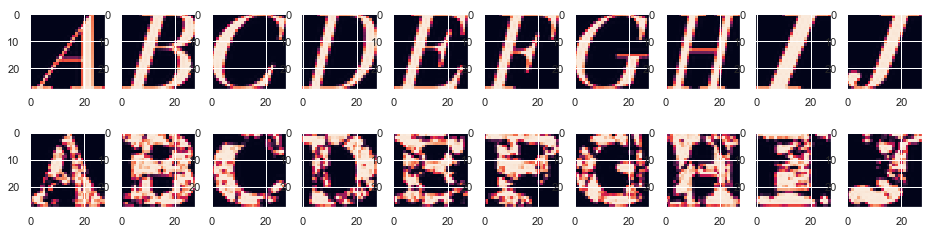

In [5]:
def print_images(number: int) -> None:
    f, ax = plt.subplots(figsize=(16, 4))
    for i,sub1 in enumerate(['notMNIST_small/', 'notMNIST_large/']):
        for j,sub2 in enumerate(['A/', 'B/', 'C/', 'D/', 'E/', 'F/', 'G/', 'H/', 'I/', 'J/']):
            plt.subplot(2, 10, 10*i+(j+1))
            img=mpimg.imread(sub1+sub2 + os.listdir(sub1+sub2)[number])
            plt.imshow(img)
    return None

print_images(10)

Transform into Datasets, safe as Pickles

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
                dataset[num_images, :, :] = image_data
                num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

.\notMNIST_large\A.pickle already present - Skipping pickling.
.\notMNIST_large\B.pickle already present - Skipping pickling.
.\notMNIST_large\C.pickle already present - Skipping pickling.
.\notMNIST_large\D.pickle already present - Skipping pickling.
.\notMNIST_large\E.pickle already present - Skipping pickling.
.\notMNIST_large\F.pickle already present - Skipping pickling.
.\notMNIST_large\G.pickle already present - Skipping pickling.
.\notMNIST_large\H.pickle already present - Skipping pickling.
.\notMNIST_large\I.pickle already present - Skipping pickling.
.\notMNIST_large\J.pickle already present - Skipping pickling.
.\notMNIST_small\A.pickle already present - Skipping pickling.
.\notMNIST_small\B.pickle already present - Skipping pickling.
.\notMNIST_small\C.pickle already present - Skipping pickling.
.\notMNIST_small\D.pickle already present - Skipping pickling.
.\notMNIST_small\E.pickle already present - Skipping pickling.
.\notMNIST_small\F.pickle already present - Skipping pi

Problem2: Look at Data in Datasets

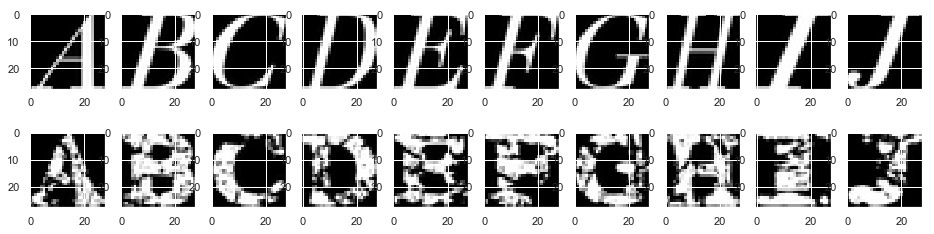

In [7]:
def print_pickle(number: int) -> None:
    f, ax = plt.subplots(figsize=(16, 4))
    for i,sub1 in enumerate(['notMNIST_small/', 'notMNIST_large/']):
        for j,sub2 in enumerate(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']):
            plt.subplot(2, 10, 10*i+(j+1))
            with open(sub1+sub2+'.pickle', 'rb') as pickle_file:
                content = pickle.load(pickle_file)
                plt.imshow(content[number], cmap='gray')
    plt.show()
    return None

print_pickle(10)

Problem3: Check if Data is balanced

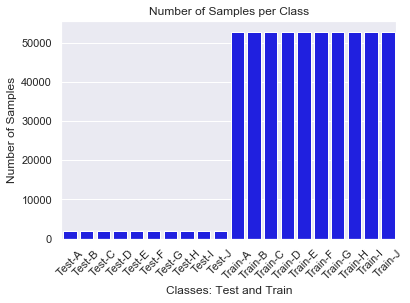

In [8]:
lengths = []
names = []
for name,sub1 in zip(['Test', 'Train'],['notMNIST_small/', 'notMNIST_large/']):
    for sub2 in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']:
        with open(sub1+sub2+'.pickle', 'rb') as pickle_file:
            lengths.append(pickle.load(pickle_file).shape[0])
            names.append(name+'-'+sub2)
ax = sns.barplot(x = names, y = lengths, color = 'blue')
plt.xticks(rotation=45)
plt.title('Number of Samples per Class')
plt.xlabel('Classes: Test and Train')
plt.ylabel('Number of Samples')
None

Train Test Val Split

In [9]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                    
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 50000
valid_size = 15000
test_size = 15000

valid_dataset, valid_labels, train_dataset, train_labels = \
    merge_datasets(train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = \
    merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (50000, 28, 28) (50000,)
Validation: (15000, 28, 28) (15000,)
Testing: (15000, 28, 28) (15000,)


Shuffling

In [10]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

Problem4: Data and Label Matching after shuffling?

Training: (50000, 28, 28) (50000,)
Validation: (15000, 28, 28) (15000,)
Testing: (15000, 28, 28) (15000,)


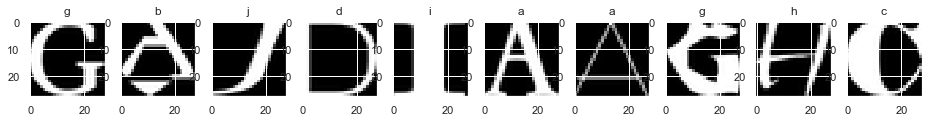

In [11]:
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

def print_dataset(number: int) -> None:
    mylabels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
    f, ax = plt.subplots(figsize=(16, 4))
    for i in range(10): 
        plt.subplot(1, 10, i+1)
        plt.imshow(train_dataset[number+i], cmap='gray')
        plt.title(mylabels[train_labels[number+i]])
    plt.show()
    return None

print_dataset(0)

Save Data for later use

In [12]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 251200502


In [13]:
# flatten matrices
train_dataset = train_dataset.reshape((len(train_dataset), 28*28))
test_dataset = test_dataset.reshape((len(test_dataset), 28*28))
valid_dataset = valid_dataset.reshape((len(valid_dataset), 28*28))

Problem5: Measure Overlap in Train, Test and Val Sets <br/>

(opt1: near duplicates?)<br/>
(opt2: create cleaned version and compare)

In [14]:
import time
import hashlib

def overlap(arr1, arr2):
    hash1 = [hashlib.sha1(x).digest() for x in arr1]
    hash2 = [hashlib.sha1(x).digest() for x in arr2]
    return np.isin(hash1, hash2)
                                                               
start = time.time()
print('train-test overlap:', sum(overlap(train_dataset, test_dataset)))
print('train-valid overlap:', sum(overlap(train_dataset, valid_dataset)))
print('valid-test overlap:', sum(overlap(valid_dataset, test_dataset)))
print('time:', time.time()-start)

#opt1:
# ..?

#opt2:
train_dataset_clean = train_dataset[~overlap(train_dataset, test_dataset) & ~overlap(train_dataset, valid_dataset)]
train_labels_clean = train_labels[~overlap(train_dataset, test_dataset) & ~overlap(train_dataset, valid_dataset)]
train_dataset_clean.shape, train_labels_clean.shape

train-test overlap: 1019
train-valid overlap: 1048
valid-test overlap: 291
time: 1.5467891693115234


((48462, 784), (48462,))

Problem 6: 

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

In [15]:
from sklearn.linear_model import LogisticRegression as LR

In [16]:
LR1 = LR()
scores = LR1.fit(train_dataset[:50], train_labels[:50]).score(test_dataset[:50], test_labels[:50])
print(scores)

0.68


In [17]:
LR2 = LR()
scores = LR2.fit(train_dataset[:100], train_labels[:100]).score(test_dataset[:100], test_labels[:100])
print(scores)

0.67


In [18]:
LR3 = LR()
scores = LR3.fit(train_dataset[:1000], train_labels[:1000]).score(test_dataset[:1000], test_labels[:1000])
print(scores)

0.83


In [19]:
LR4 = LR()
scores = LR4.fit(train_dataset[:5000], train_labels[:5000]).score(test_dataset[:5000], test_labels[:5000])
print(scores)

0.8564


In [20]:
LR5 = LR()
scores = LR5.fit(train_dataset, train_labels).score(test_dataset, test_labels)
print(scores)

0.8854666666666666
